In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import spectrogram, get_window
from IPython.display import Audio

# Función para graficar el espectrograma
def plot_spectrogram(signal, sample_rate, overlapping = 0., window_type='hann', window_size=256):
    """
    Genera y grafica el espectrograma de una señal.

    Parámetros:
    - signal: la señal de audio
    - window_type: el tipo de ventana a usar (string, por ejemplo 'hann', 'hamming', etc.)
    - window_size: tamaño de la ventana (entero)
    - overlapping: porcentaje de solapamiento (valor entre 0 y 1)
    - fs: frecuencia de muestreo de la señal
    """
    # Crear la ventana
    window = get_window(window_type, window_size)

    # Calcular el paso de la ventana en función del solapamiento
    noverlap = int(overlapping * window_size)

    # Calcular el espectrograma usando scipy.signal.spectrogram
    f, t, Sxx = spectrogram(signal, fs=sample_rate, window=window,
                            nperseg=window_size, noverlap=noverlap)


    # Graficar el espectrograma
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Espectrograma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud [dB]')
    plt.show()


Canal 1 - Tamaño de señal: (3000,)


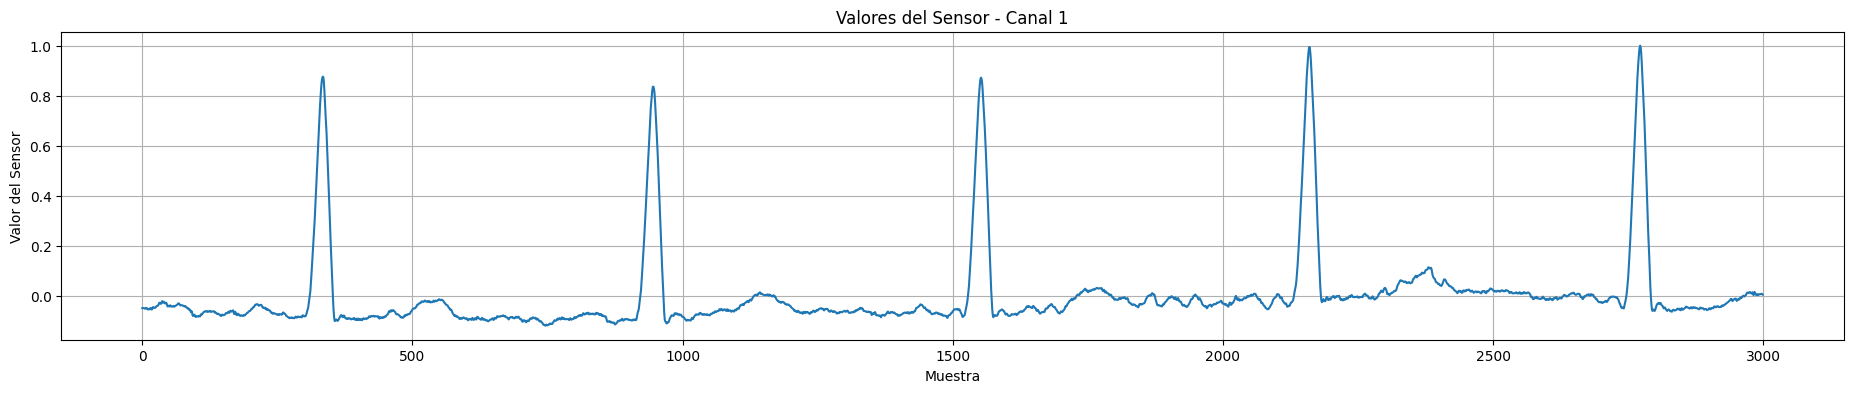

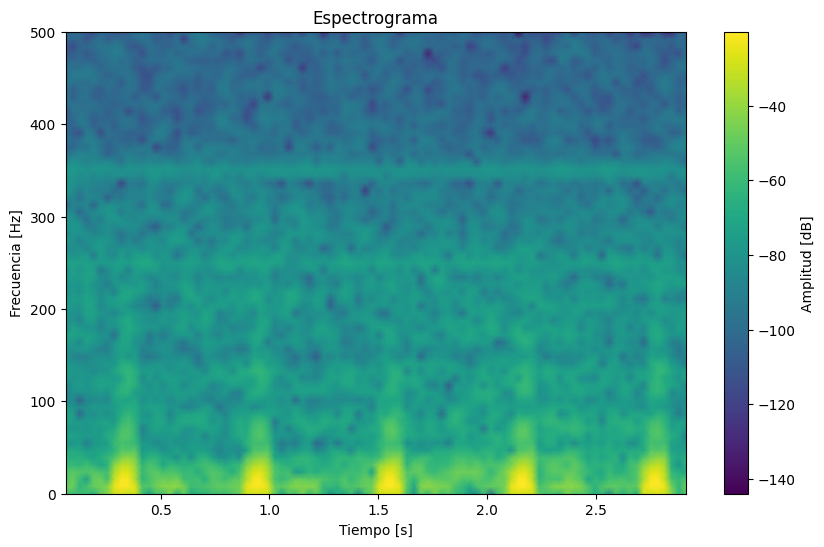

Canal 2 - Tamaño de señal: (3000,)


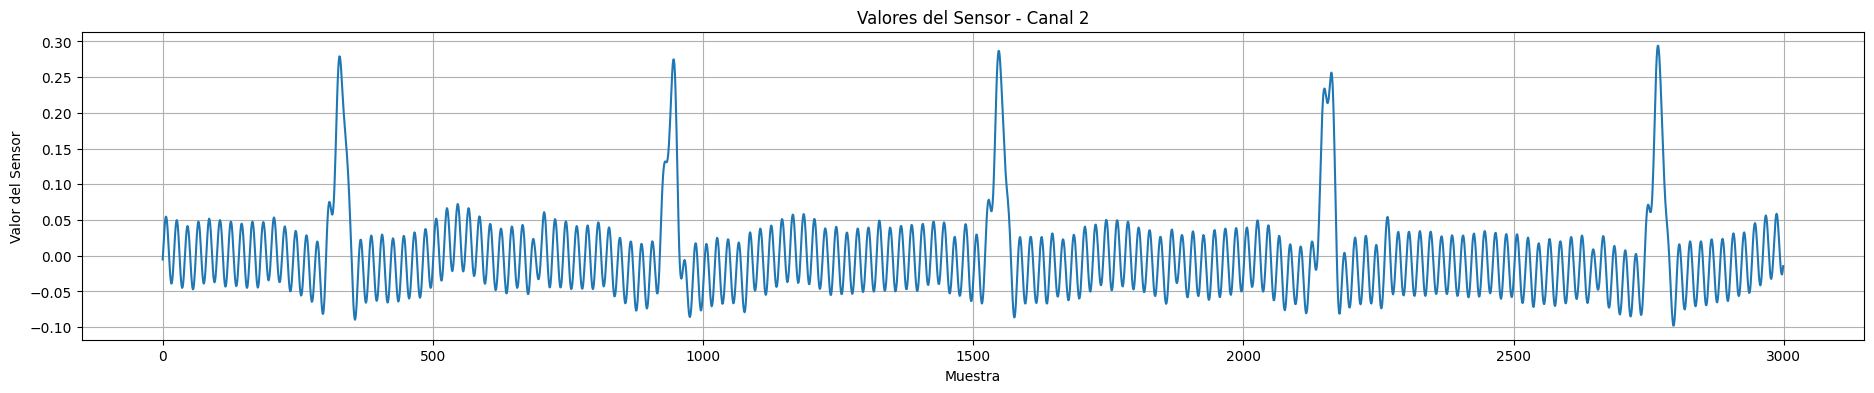

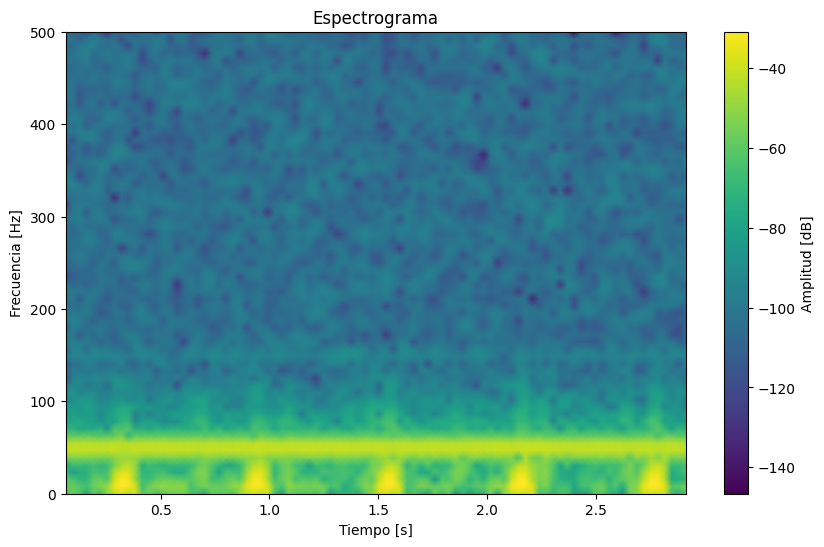

Canal 3 - Tamaño de señal: (3000,)


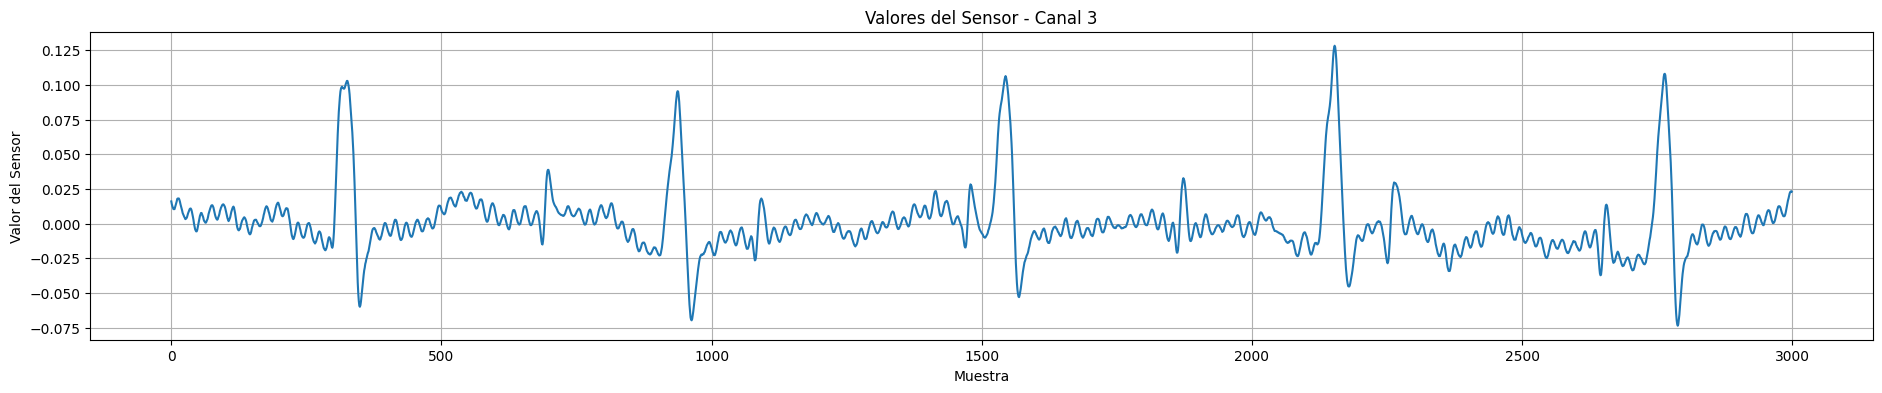

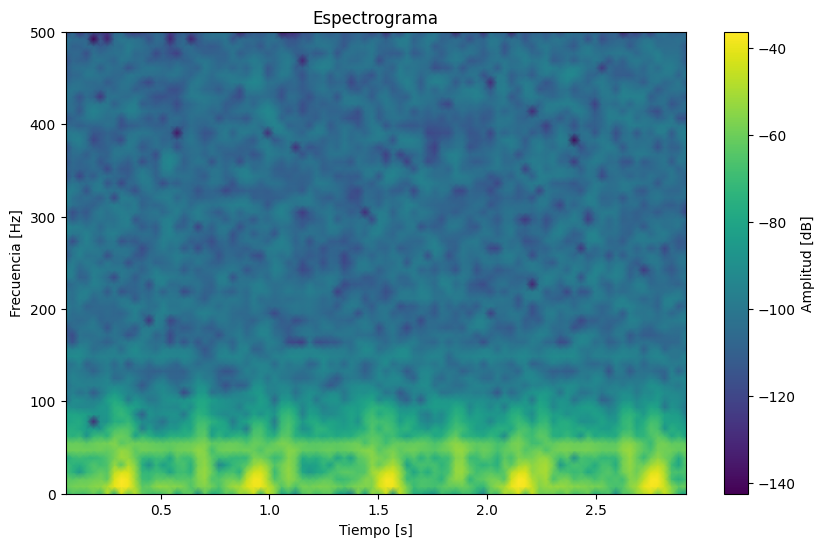

Canal 4 - Tamaño de señal: (3000,)


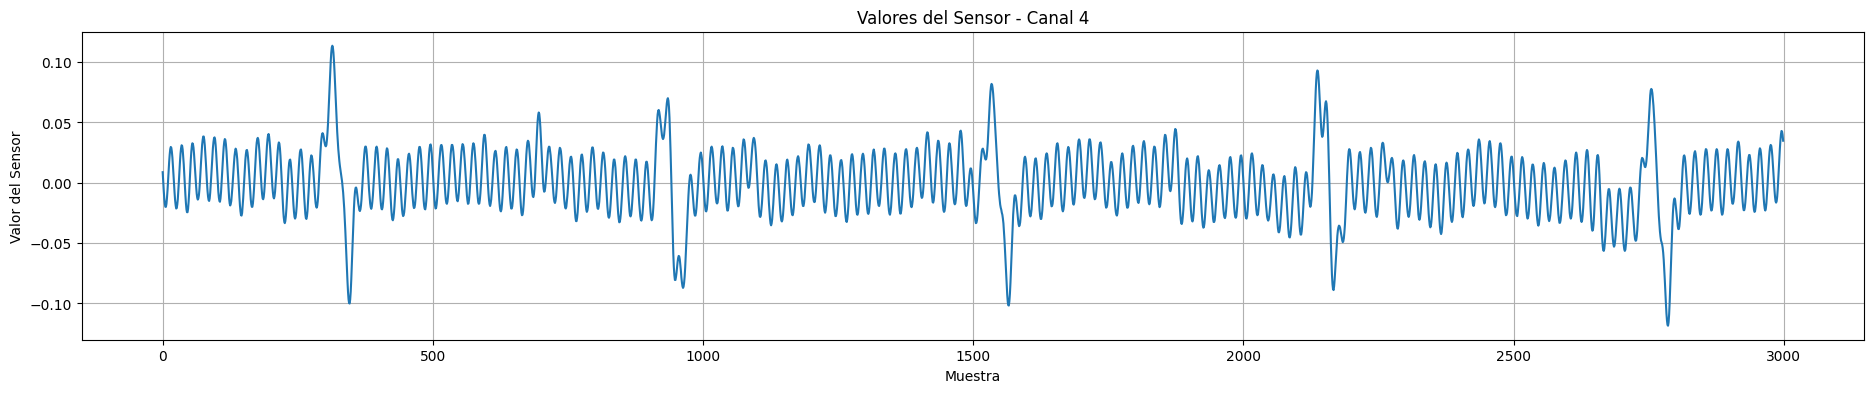

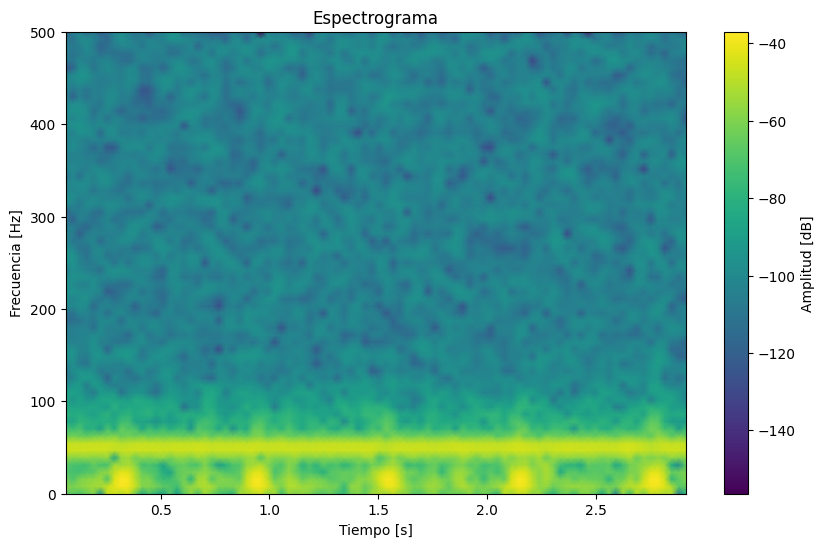

Canal 5 - Tamaño de señal: (3000,)


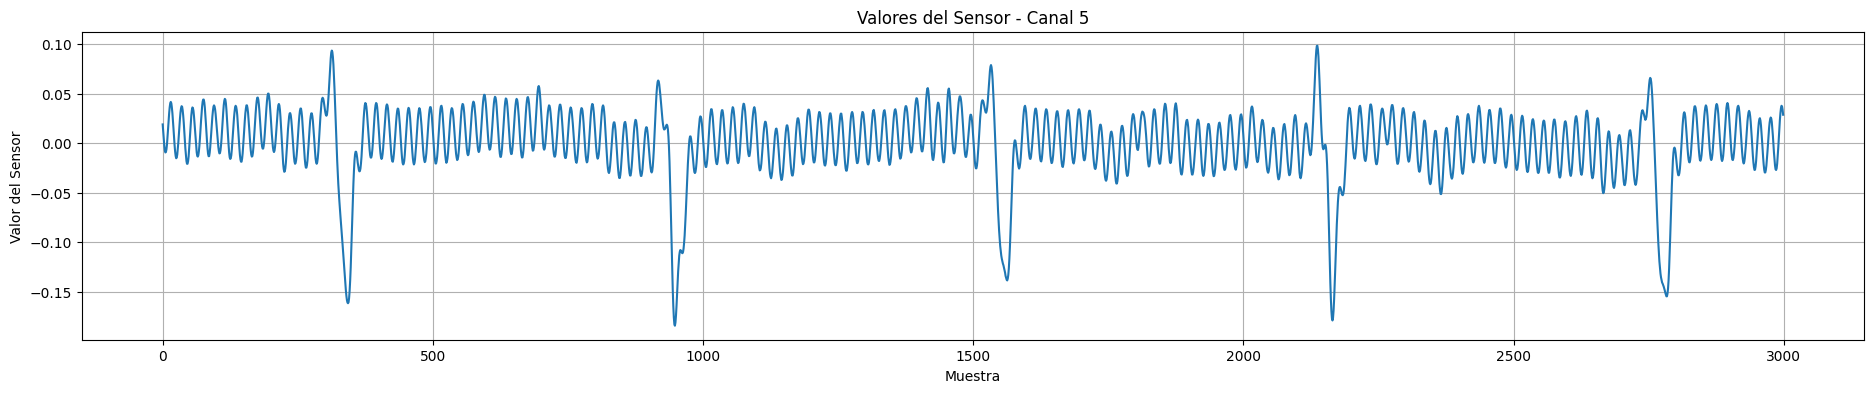

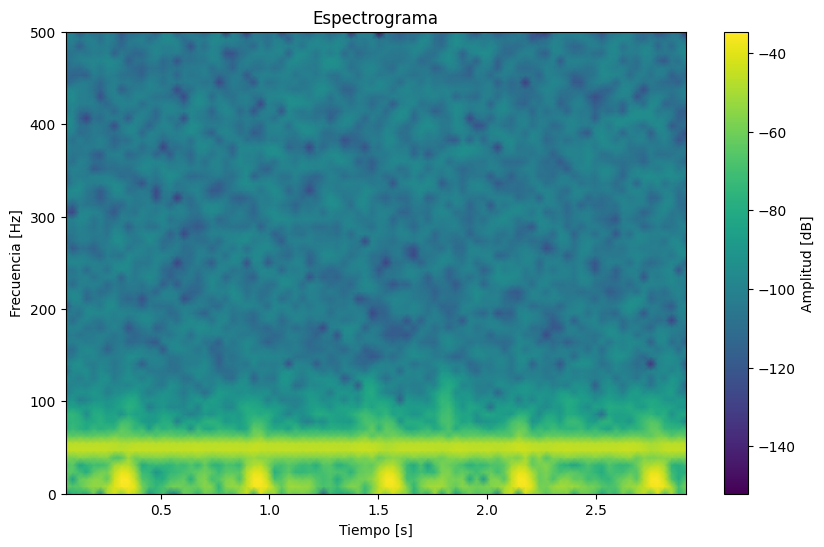

Canal 6 - Tamaño de señal: (3000,)


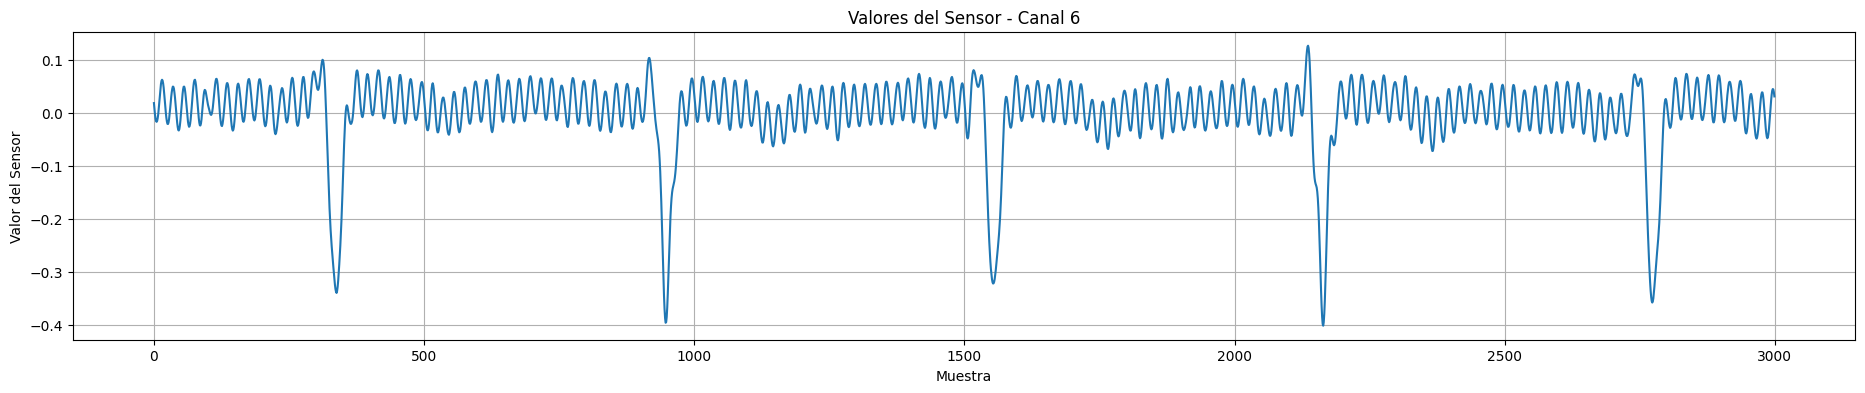

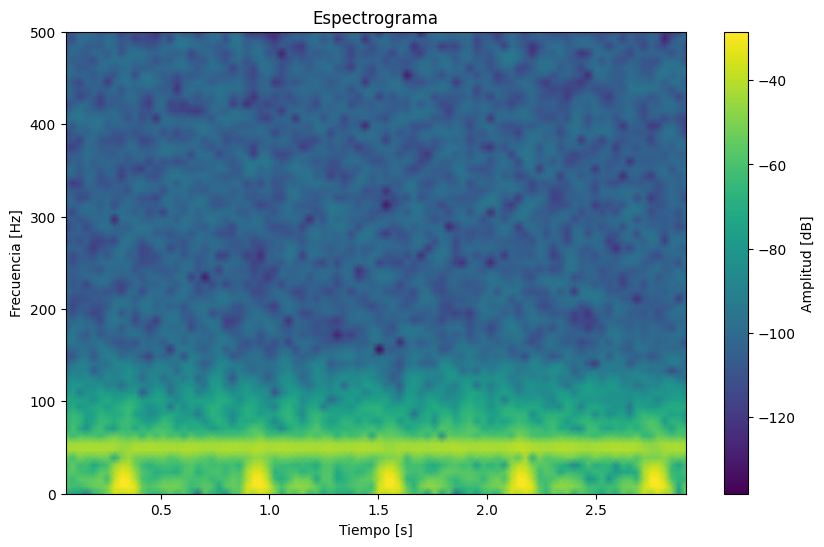

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, get_window

# Nombre del archivo sin extensión
record_name = 'NIFAECG/NR_02'

# Cargar el archivo .dat y su metainformación
record = wfdb.rdrecord(record_name)

# Acceder a los datos de la señal (todas las señales)
signals = record.p_signal[3000:6000, :]  # Cargar un segmento específico
n_channels = signals.shape[1]  # Número de canales

# Configuración de la frecuencia de muestreo (asegúrate de que sea correcta)
sample_rate = record.fs

#normalizar la señal
signals = signals/np.max(np.abs(signals))

# Graficar cada canal y su espectrograma
for i in range(n_channels):
    print(f"Canal {i+1} - Tamaño de señal: {signals[:, i].shape}")

    # Graficar la señal de tiempo
    plt.figure(figsize=(23, 4))
    plt.plot(signals[:, i])
    plt.xlabel('Muestra')
    plt.ylabel('Valor del Sensor')
    plt.title(f'Valores del Sensor - Canal {i+1}')
    plt.grid(True)
    plt.show()
    
    # Graficar el espectrograma
    plot_spectrogram(signals[:, i], sample_rate, overlapping=0.75, window_type='hann', window_size=128)


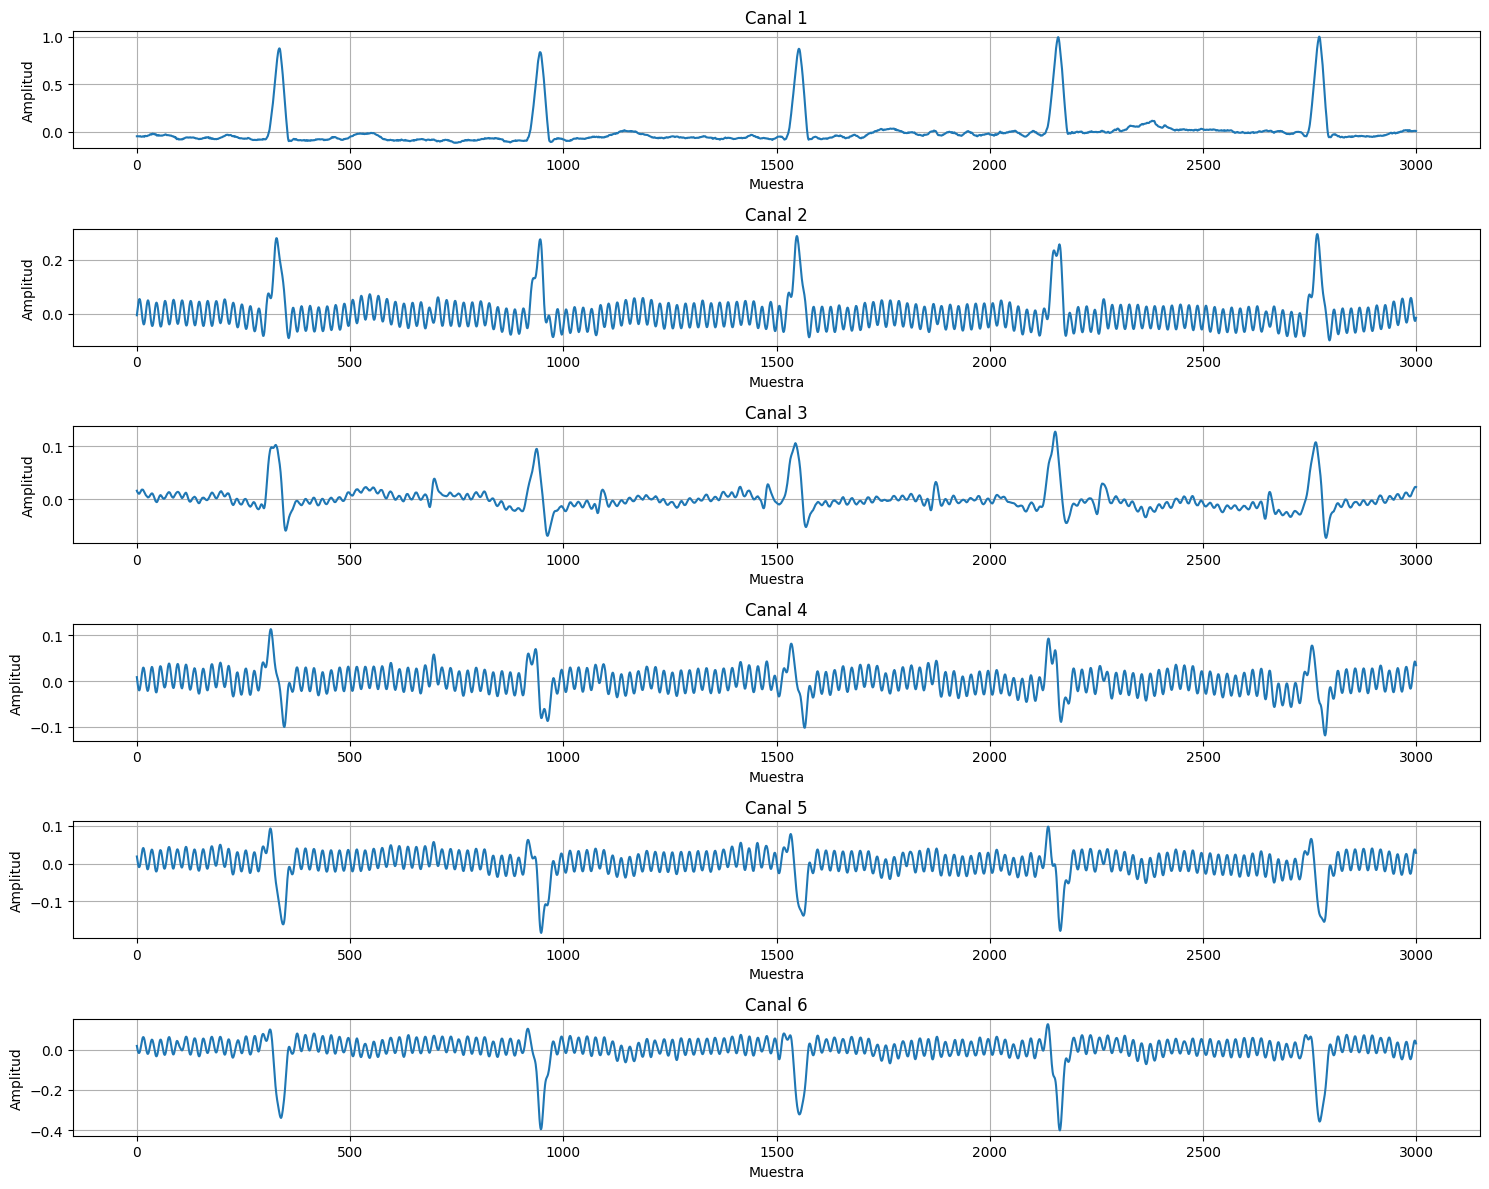

In [3]:
# Graficar todos los canales en subplots
plt.figure(figsize=(15, 2 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(signals[:, i])
    plt.title(f'Canal {i+1}')
    plt.xlabel('Muestra')
    plt.ylabel('Amplitud')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
sample_rate = record.fs  # Frecuencia de muestreo, por ejemplo, 500 Hz o 1 kHz
print(f"Frecuencia de muestreo: {sample_rate} Hz")


Frecuencia de muestreo: 1000 Hz


In [5]:
num_samples = signals.shape[0]  # Número de muestras en el segmento
nyquist_interval = sample_rate / 2  # Intervalo de Nyquist
print(f"Número de muestras: {num_samples}")
print(f"Intervalo de Nyquist: {nyquist_interval} Hz")


Número de muestras: 3000
Intervalo de Nyquist: 500.0 Hz


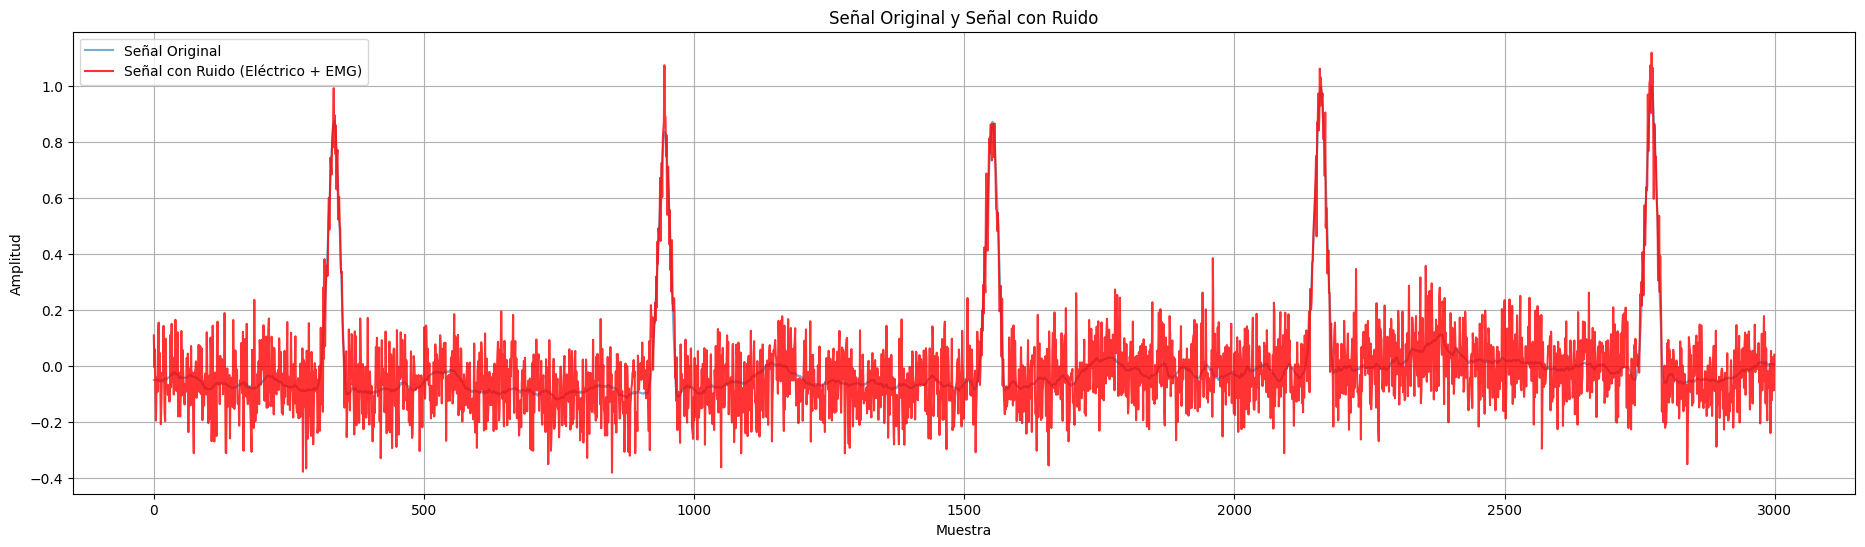

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generar ruido eléctrico (50 Hz)
def generate_electrical_noise(frequency, sample_rate, duration, amplitude=0.05):
    t = np.arange(0, duration, 1/sample_rate)
    noise = amplitude * np.sin(2 * np.pi * frequency * t)
    return noise

# Generar ruido EMG (ruido blanco)
def generate_emg_noise(sample_rate, num_samples, amplitude=0.05):
    emg_noise = amplitude * np.random.normal(0, 1, num_samples)
    return emg_noise

# Parámetros de la señal
sample_rate = record.fs
fs = record.fs  # Frecuencia de muestreo
num_samples = signals.shape[0]
duration = num_samples / sample_rate  # Duración en segundos

# Generar ruido eléctrico y ruido EMG
electrical_noise = generate_electrical_noise(50, fs, duration, amplitude=0.02)
emg_noise = generate_emg_noise(fs, num_samples, amplitude=0.1)

# Agregar ruido a la señal original (por ejemplo, al primer canal)
noisy_signal = signals[:, 0] + electrical_noise + emg_noise

# Graficar la señal original y la señal con ruido
plt.figure(figsize=(23, 6))
plt.plot(signals[:, 0], label='Señal Original', alpha=0.6)
plt.plot(noisy_signal, label='Señal con Ruido (Eléctrico + EMG)', alpha=0.8, color='r')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.title('Señal Original y Señal con Ruido')
plt.legend()
plt.grid(True)
plt.show()


SNR antes del filtrado: 4.30 dB
SNR después del filtrado: 9.11 dB


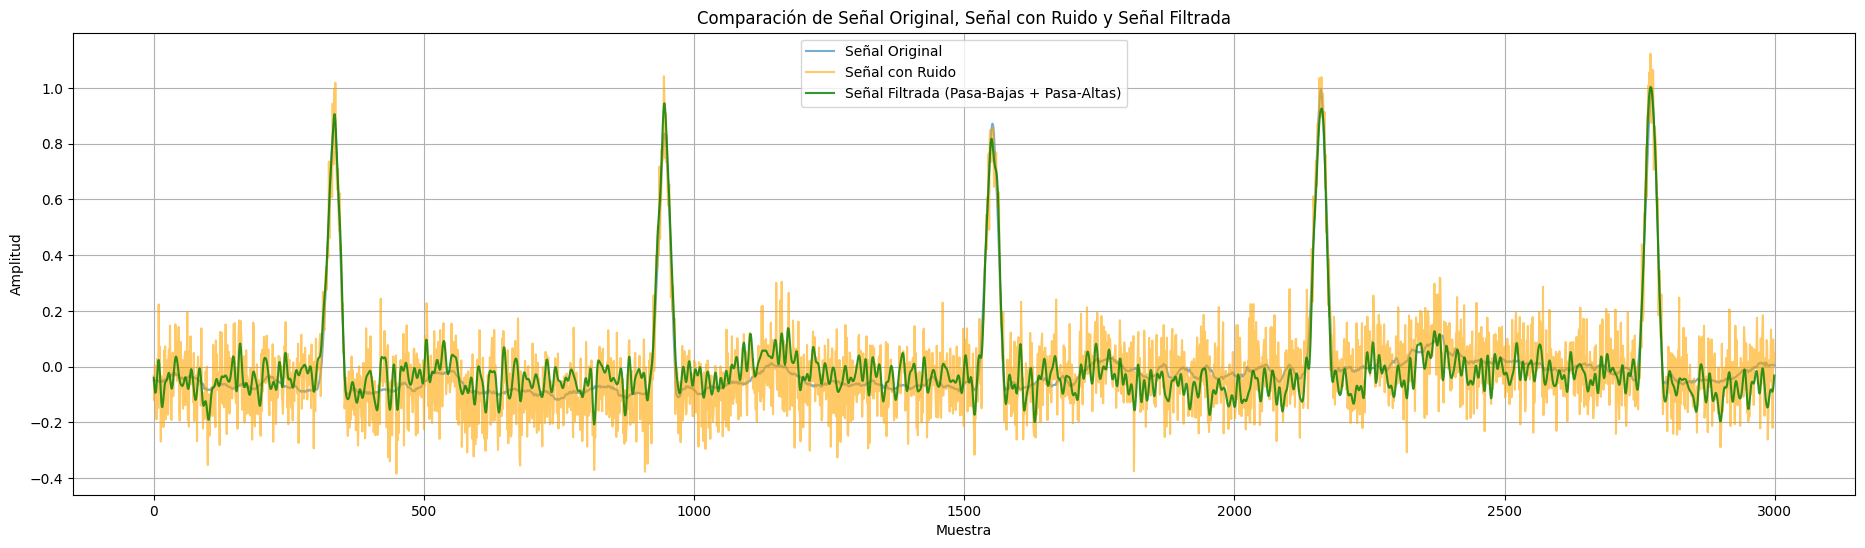

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Función para calcular la relación señal-ruido (SNR)
def calculate_snr(original_signal, noisy_signal):
    signal_power = np.mean(original_signal ** 2)
    noise_power = np.mean((original_signal - noisy_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Función para diseñar y aplicar un filtro Butterworth
def butter_filter(signal, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Parámetros de la señal
fs = record.fs  # Frecuencia de muestreo
cutoff_low = 100  # Frecuencia de corte para el filtro pasa-bajas
cutoff_high = 0.5  # Frecuencia de corte para el filtro pasa-altas

# Generar ruido eléctrico y ruido EMG
electrical_noise = generate_electrical_noise(50, fs, duration, amplitude=0.02)
emg_noise = generate_emg_noise(fs, num_samples, amplitude=0.1)

# Agregar ruido a la señal original
noisy_signal = signals[:, 0] + electrical_noise + emg_noise

# Calcular SNR antes del filtrado
snr_before = calculate_snr(signals[:, 0], noisy_signal)
print(f"SNR antes del filtrado: {snr_before:.2f} dB")

# Aplicar filtro pasa-bajas y pasa-altas
filtered_signal_low = butter_filter(noisy_signal, cutoff_low, fs, order=5, filter_type='low')
filtered_signal_high = butter_filter(filtered_signal_low, cutoff_high, fs, order=5, filter_type='high')

# Calcular SNR después del filtrado
snr_after = calculate_snr(signals[:, 0], filtered_signal_high)
print(f"SNR después del filtrado: {snr_after:.2f} dB")

# Graficar las señales
plt.figure(figsize=(23, 6))
plt.plot(signals[:, 0], label='Señal Original', alpha=0.6)
plt.plot(noisy_signal, label='Señal con Ruido', alpha=0.6, color='orange')
plt.plot(filtered_signal_high, label='Señal Filtrada (Pasa-Bajas + Pasa-Altas)', alpha=0.8, color='green')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.title('Comparación de Señal Original, Señal con Ruido y Señal Filtrada')
plt.legend()
plt.grid(True)
plt.show()



Procesando Canal 1
SNR antes del filtrado: 8.48 dB
SNR después del filtrado: 9.14 dB


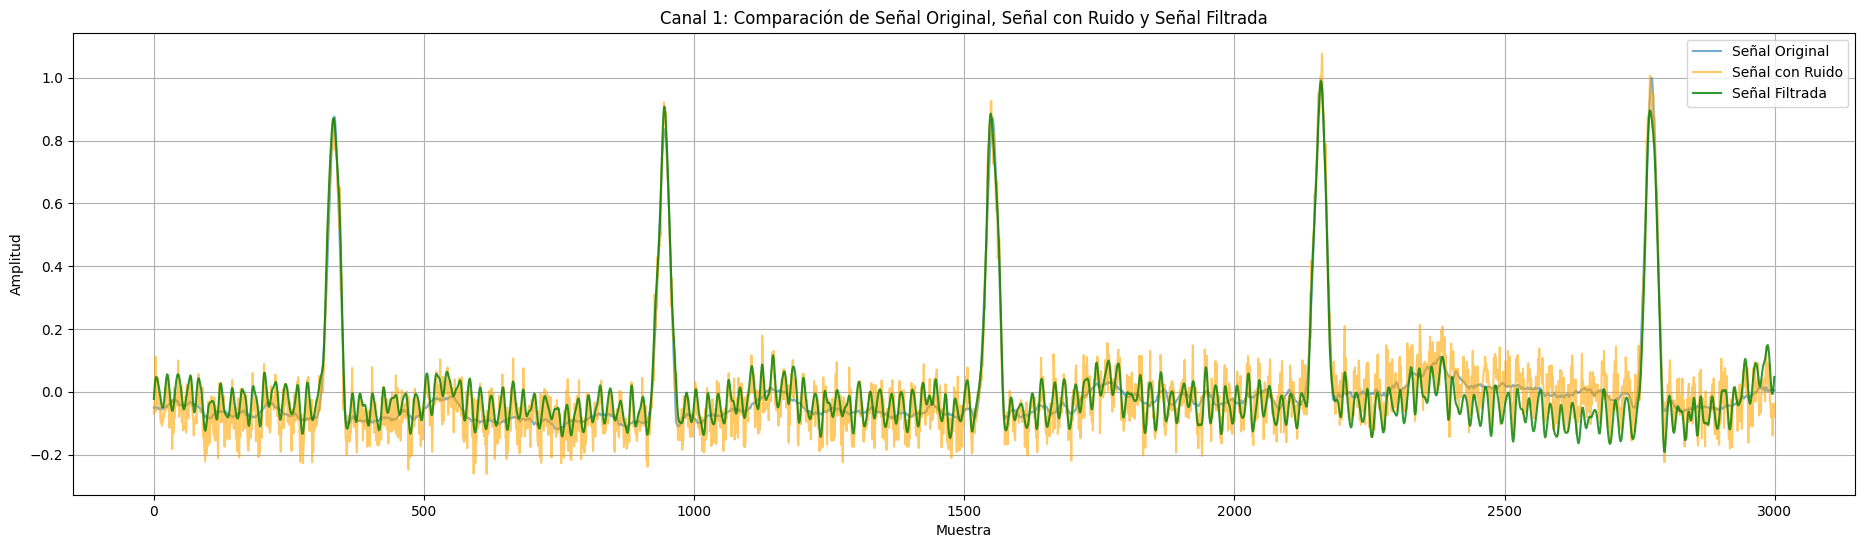


Procesando Canal 2
SNR antes del filtrado: -0.68 dB
SNR después del filtrado: 2.11 dB


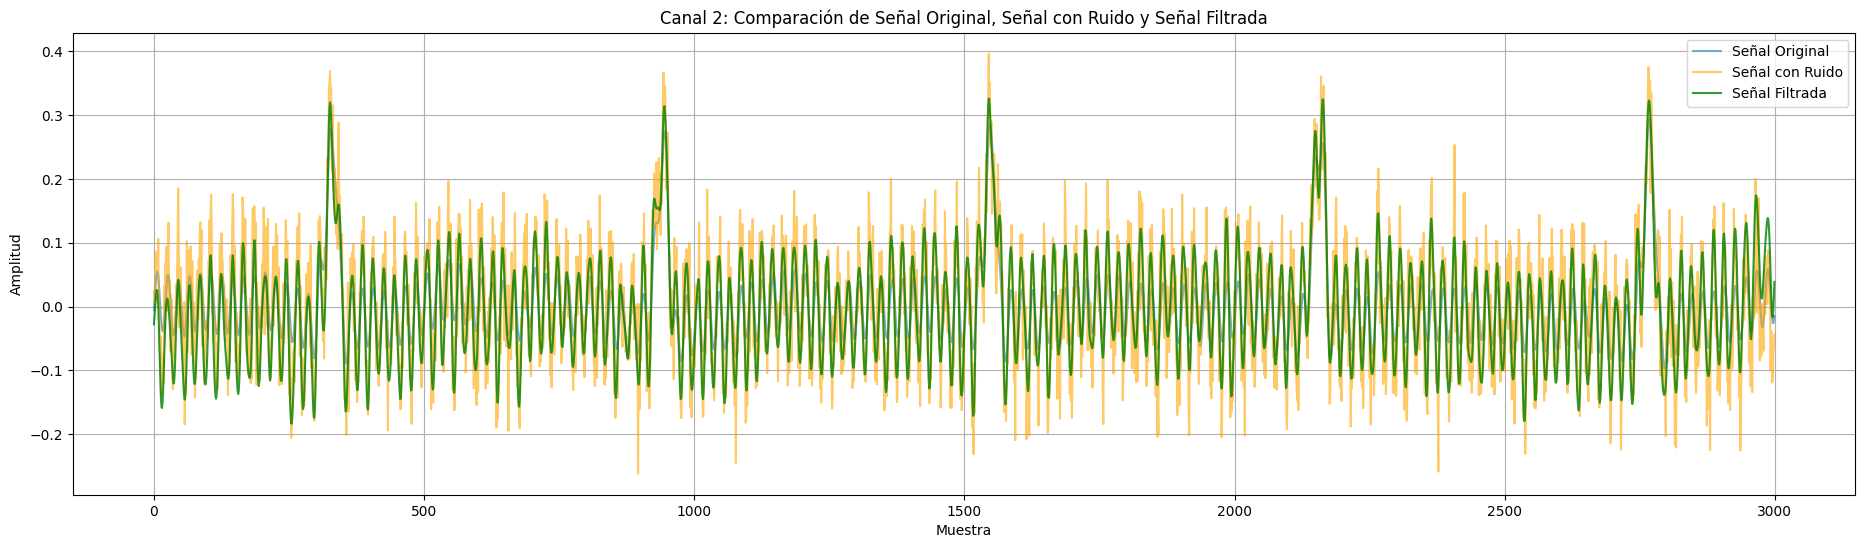


Procesando Canal 3
SNR antes del filtrado: -8.41 dB
SNR después del filtrado: -7.20 dB


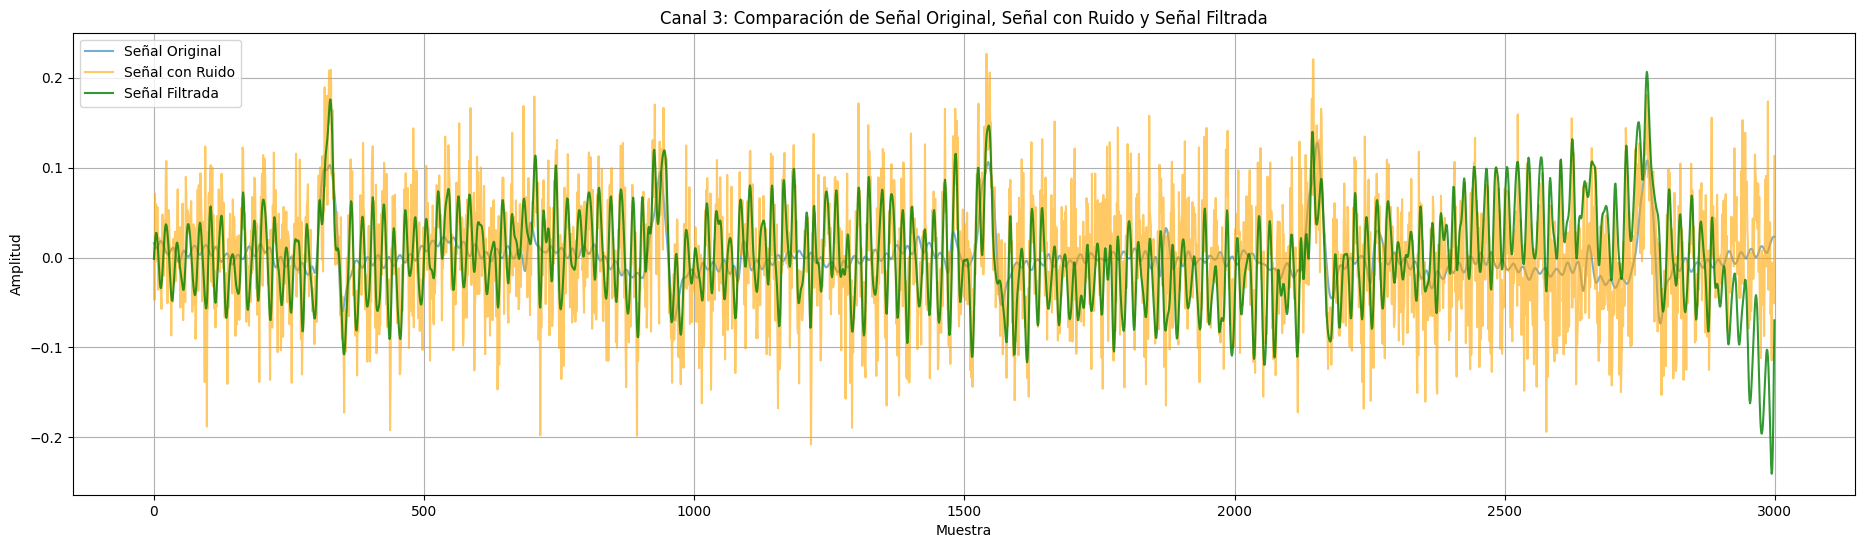


Procesando Canal 4
SNR antes del filtrado: -7.21 dB
SNR después del filtrado: -4.82 dB


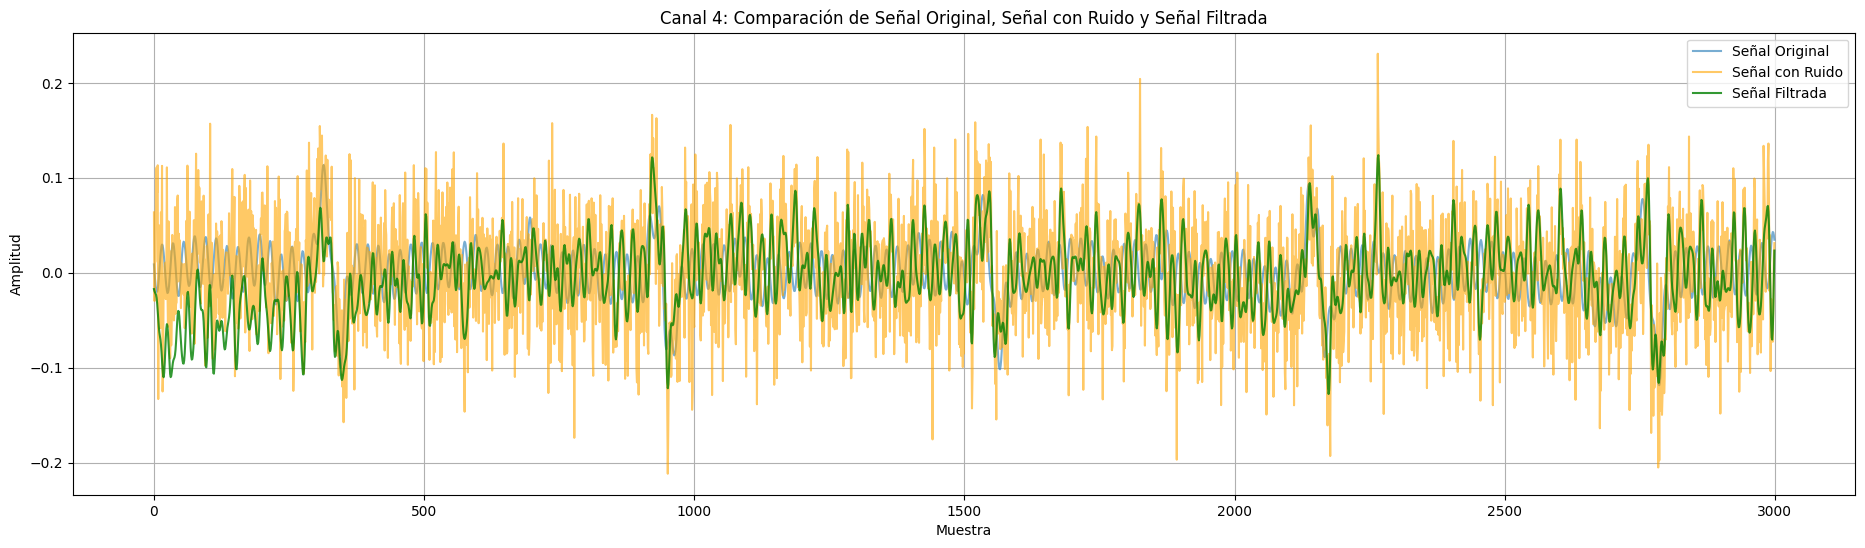


Procesando Canal 5
SNR antes del filtrado: -4.93 dB
SNR después del filtrado: -1.74 dB


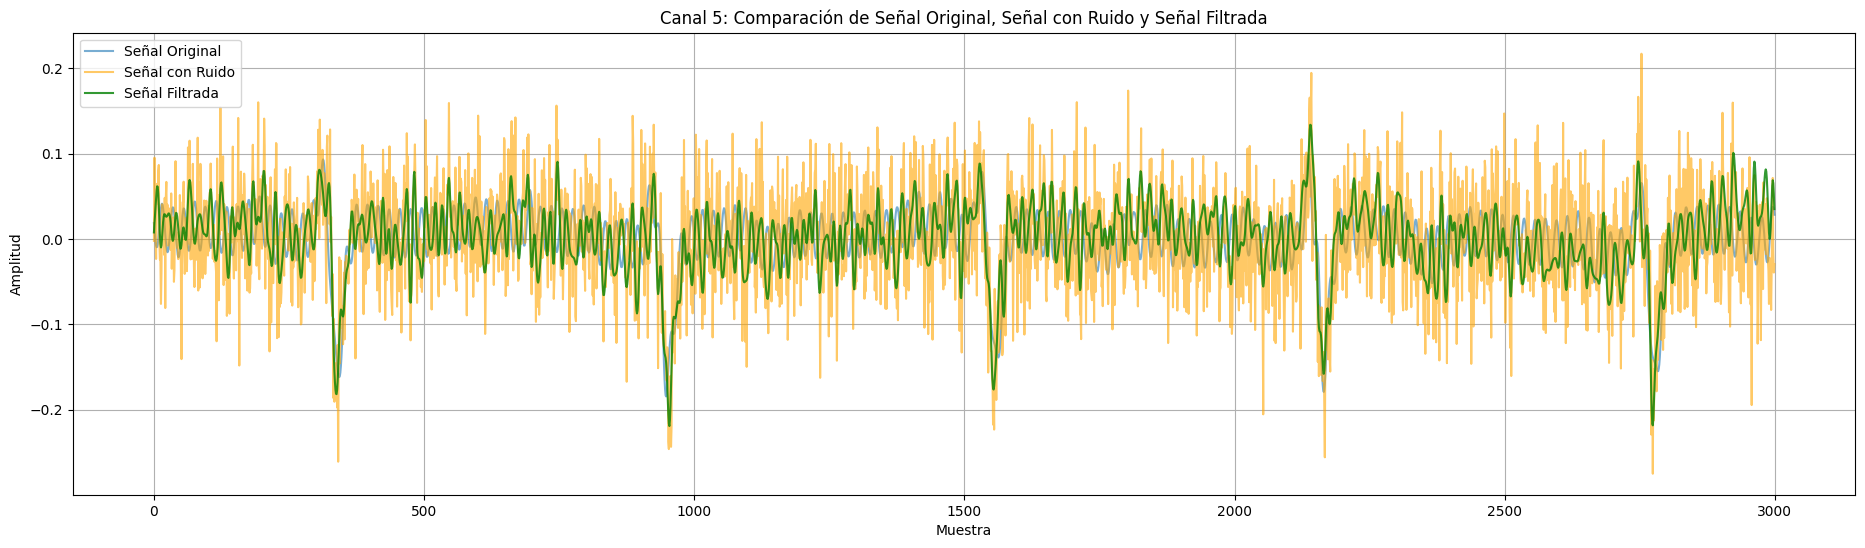


Procesando Canal 6
SNR antes del filtrado: 0.81 dB
SNR después del filtrado: 3.30 dB


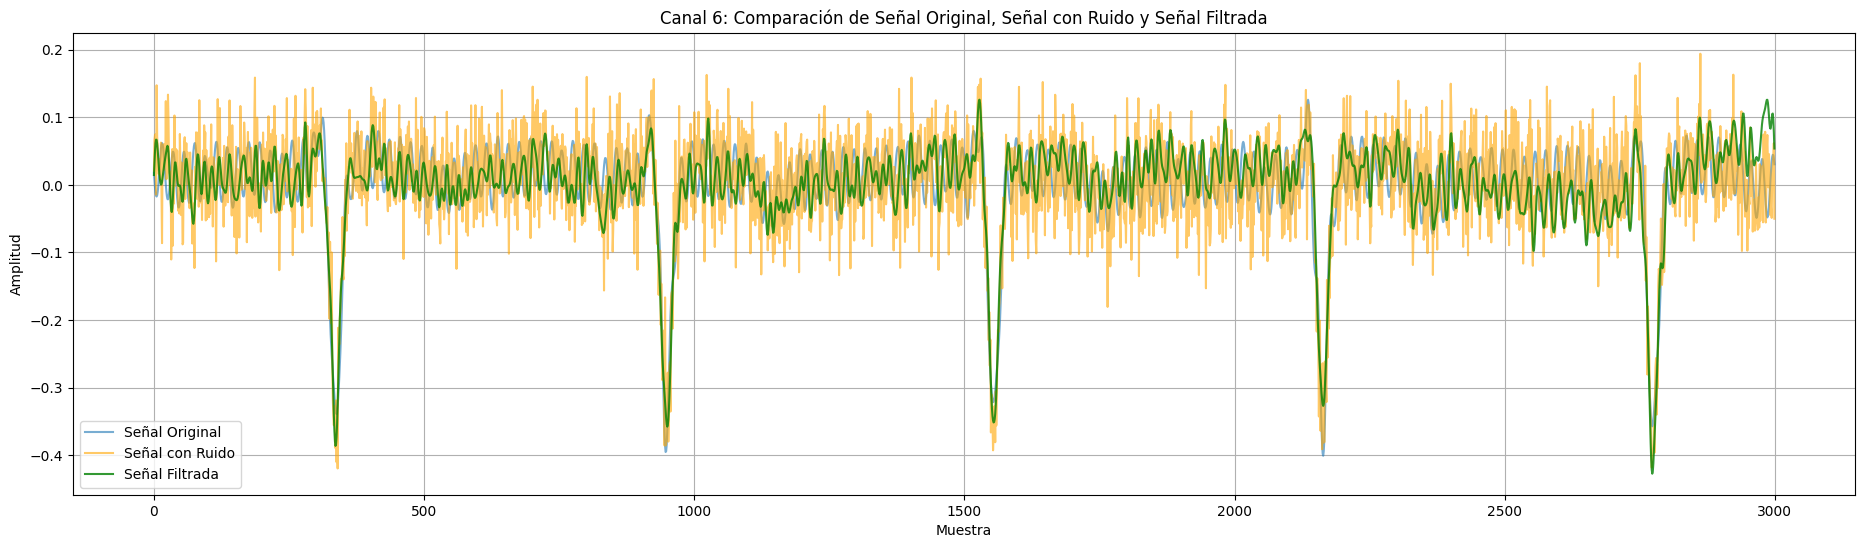

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Función para calcular la relación señal-ruido (SNR)
def calculate_snr(original_signal, processed_signal):
    signal_power = np.mean(original_signal ** 2)
    noise_power = np.mean((original_signal - processed_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Función para diseñar y aplicar un filtro Butterworth
def butter_filter(signal, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Parámetros de la señal
fs = record.fs  # Frecuencia de muestreo
cutoff_low = 100  # Frecuencia de corte para el filtro pasa-bajas
cutoff_high = 0.5  # Frecuencia de corte para el filtro pasa-altas
num_samples = signals.shape[0]
duration = num_samples / fs  # Duración en segundos

n_channels = signals.shape[1]  # Número de canales

# Iterar sobre cada canal
for i in range(n_channels):
    print(f"\nProcesando Canal {i+1}")

    original_signal = signals[:, i]

    # Generar ruido eléctrico y ruido EMG para este canal
    electrical_noise = generate_electrical_noise(50, fs, duration, amplitude=0.05)
    emg_noise = generate_emg_noise(fs, num_samples, amplitude=0.05)

    # Agregar ruido a la señal original
    noisy_signal = original_signal + electrical_noise + emg_noise

    # Calcular SNR antes del filtrado
    snr_before = calculate_snr(original_signal, noisy_signal)
    print(f"SNR antes del filtrado: {snr_before:.2f} dB")

    # Aplicar filtro pasa-bajas y pasa-altas
    filtered_signal_low = butter_filter(noisy_signal, cutoff_low, fs, order=5, filter_type='low')
    filtered_signal = butter_filter(filtered_signal_low, cutoff_high, fs, order=5, filter_type='high')

    # Calcular SNR después del filtrado
    snr_after = calculate_snr(original_signal, filtered_signal)
    print(f"SNR después del filtrado: {snr_after:.2f} dB")

    # Graficar las señales
    plt.figure(figsize=(23, 6))
    plt.plot(original_signal, label='Señal Original', alpha=0.6)
    plt.plot(noisy_signal, label='Señal con Ruido', alpha=0.6, color='orange')
    plt.plot(filtered_signal, label='Señal Filtrada', alpha=0.8, color='green')
    plt.xlabel('Muestra')
    plt.ylabel('Amplitud')
    plt.title(f'Canal {i+1}: Comparación de Señal Original, Señal con Ruido y Señal Filtrada')
    plt.legend()
    plt.grid(True)
    plt.show()
